In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.model_selection import train_test_split
import json
import glob
import random
import collections
from glob import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

from skimage.io import imread
from skimage.transform import resize
from keras import layers
from keras import models
import keras
from keras.layers import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import shutil
import keras
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import keras
import json
import tensorflow as tf 
from keras.layers import Input
from keras import Sequential
from keras.layers import Dense, LSTM,Flatten, TimeDistributed, Conv2D, Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16

In [3]:
#load 4000 of MNIST data for train and 400 for testing
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_full = x_train[:4000] / 255
y_full = y_train[:4000]
x_test = x_test[:400] /255
y_test = y_test[:400]
x_full.shape, y_full.shape, x_test.shape, y_test.shape

((4000, 28, 28), (4000,), (400, 28, 28), (400,))

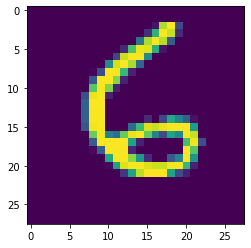

In [4]:
plt.imshow(x_full[3999])

In [5]:
#build computation graph
x = tf.placeholder(tf.float32, [None, 28, 28])
x_flat = tf.reshape(x, [-1, 28 * 28])
y_ = tf.placeholder(tf.int32, [None])
W = tf.Variable(tf.zeros([28 * 28, 10]), tf.float32)
b = tf.Variable(tf.zeros([10]), tf.float32)
y = tf.matmul(x_flat, W) + b
y_sm = tf.nn.softmax(y)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, logits=y))
train = tf.train.AdamOptimizer(0.1).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(y_, tf.cast(tf.argmax(y, 1), tf.int32)), tf.float32))

AttributeError: module 'tensorflow' has no attribute 'placeholder'